### Titanic Kaggle Contest
Predict if passengers will survive

#### Steps
1. Import data
2. Clean Data
3. Analyze / Feature engineer
4. Test Models
5. Improve model with random search
6. Predict using test dataset

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [67]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_ids = test["PassengerId"]

In [68]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [70]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [79]:
def clean_data(df):
    #DATA CLEANING
    #drop the name, ticket, passengerid
    df = df.drop(['Name','Ticket','PassengerId'], axis=1)
    #fill in age with mean
    df['Age'] = df['Age'].fillna(df['Age'].median())
    #fill in cabin with unknown and keep only the section
    df['Cabin'] = df['Cabin'].fillna('U')
    #fill in embarked
    df['Embarked'] = df['Embarked'].fillna('U')
    ## Nice to haves
    # Split fare into quartiles
    #df['Fare'] = pd.qcut(df_train.Fare.rank(method='first'), 5, labels=False)
    df['Cabin'] = df['Cabin'].str[0]
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    return df

    

df_train = clean_data(train)
df_test = clean_data(test)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,U,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,U,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,U,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,U,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,28.0,1,2,23.4500,U,S
889,1,1,male,26.0,0,0,30.0000,C,C


In [83]:
# Labels for Sex, Cabin, and Embarked
from sklearn.preprocessing import LabelEncoder

cols = ['Sex','Cabin','Embarked']

def encode(df, cols):
    le = LabelEncoder()
    for col in cols:
        df[col] = le.fit_transform(df[col])
    return df

df_train = encode(df_train, cols)
df_test = encode(df_test, cols)

In [8]:
X = df_train.drop(['Survived'], axis=1)
y = df_train.Survived

   Logistic Regression  LinearSVC  KNeighbors  XG_Boost
0             0.787873   0.794595    0.708204  0.819346


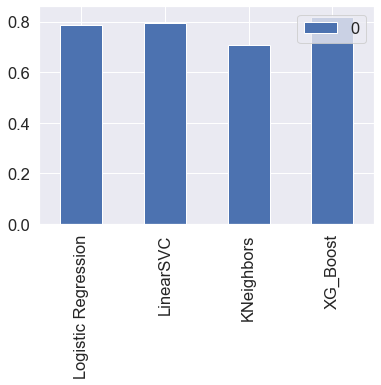

In [57]:
# Test Models - Logistic Regression, Linear SVC, and KNeighbors
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

clf_lr = LogisticRegression(max_iter=20000, C= 3.1647368421052633)
clf_lsvc = LinearSVC(max_iter=20000, multi_class='ovr', C=0.01)
clf_knn = KNeighborsClassifier()
clf_xgb = xgb.XGBClassifier(seed=2, use_label_encoder=False, verbosity=0, max_depth=6)

model_columns = ['Logistic Regression','LinearSVC','KNeighbors', 'XG_Boost']
models = [clf_lr, clf_lsvc, clf_knn, clf_xgb]
scores = []
#Train and score
for model in models:
    score = cross_val_score(model, X, y, cv=5, n_jobs=-1).mean()
    scores.append(score)
    
scores = pd.DataFrame([scores], columns=model_columns)
scores.T.plot(kind='bar');
print(scores)

In [58]:
# Optimize each model using RandomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

distributions = [{'C': np.linspace(0.01, 10, 20)},
                 {'C': np.linspace(0.01, 10, 20),
                  'multi_class': ['ovr', 'crammer_singer']},
                 {'max_depth': range(1,20,1)}]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)


clf = RandomizedSearchCV(models[1], distributions[1], n_iter=50, n_jobs=-1, random_state=2, cv=5)
clf = clf.fit(X, y)
print(clf.best_params_)
clf.score(X_val, y_val)

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'multi_class': 'ovr', 'C': 0.01}


C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7597765363128491

In [59]:
y_preds = clf.predict(X_val)
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_preds)

0.7597765363128491

### Stacking Classifiers

In [80]:
from sklearn.ensemble import StackingClassifier

clf_lr = LogisticRegression(max_iter=20000, C= 3.1647368421052633)
clf_lsvc = LinearSVC(max_iter=20000, multi_class='ovr', C=0.01)
clf_xgb = xgb.XGBClassifier(seed=2, use_label_encoder=False, verbosity=0, max_depth=6)

estimators = [
    ('LR',clf_lr),
    ('LSVC', clf_lsvc),
    ('clf_xgb', clf_xgb)
]

clf = StackingClassifier(estimators=estimators)

clf.fit(X_train, y_train).score(X_val, y_val)

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndar

0.7877094972067039

In [84]:
df_test.isna().sum()
submission_predictions = clf.predict(df_test)

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Conclusion - Evaluation of Model
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Prescision
* Recall
* F1-score

[[97  3]
 [ 4 75]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       0.96      0.95      0.96        79

    accuracy                           0.96       179
   macro avg       0.96      0.96      0.96       179
weighted avg       0.96      0.96      0.96       179



C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


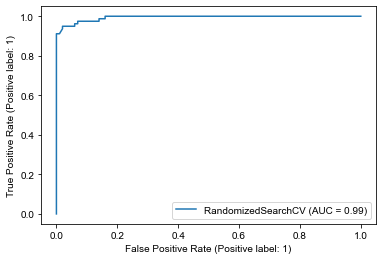

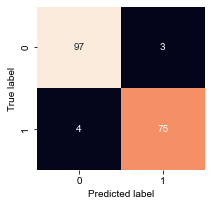

In [14]:
# Make predittion with tuned model
y_preds = clf.predict(X_val)

# Import Model Evaluations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Plot ROC curve and calculate AUC metric for rs_rf
plot_roc_curve(clf, X_val, y_val)

#### ROC Curve and AUC Score

# Confusion matrix
print(confusion_matrix(y_val, y_preds))

#### Confusion Matrix

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_val, y_preds),
                    annot=True,
                    cbar = False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    sns.set(font_scale=1.5)

plot_conf_mat(y_val, y_preds)

#### Classification report

print(classification_report(y_val, y_preds))

##### Calculate evaluation metrics using cross-validation
Calculate accuracy, precision, recall, f1-score of the best model using cross-validation function `cross_val_score()`

In [15]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

# Cross-validated precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring="precision")
cv_precision = np.mean(cv_precision)
cv_precision

# Cross-validated recall
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

# Cross-validated f1 score
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\molli\anaconda3\envs\ml\lib\site-packages

0.7379484407348186

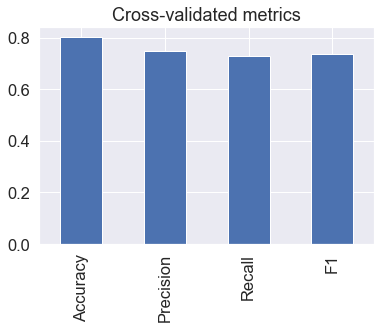

In [16]:
# Visualize cross-vlaidated metrics

metric_scores = {"Accuracy": cv_acc,
        "Precision": cv_precision,
        "Recall": cv_recall,
        "F1": cv_f1}
arr = np.array(metric_scores)
#print(arr)

cv_metrics = pd.DataFrame(metric_scores, index=[0])

cv_metrics.T.plot.bar(title="Cross-validated metrics", legend=False );

## Submission to Contest

In [19]:
submission_predictions = clf.predict(df_test)

C:\Users\molli\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [85]:
df_sub = pd.DataFrame({"PassengerId": test_ids.values,
                       "Survived": submission_predictions})


In [86]:
df_sub.to_csv("contest_submission.csv", index=False)